# RISK Probability Engine Experiments

## Overview
This notebook documents my experiments in developing a probability engine for my Python-based RISK game replica.  
The goal is to accurately estimate the probability of winning a battle given specific attacker/defender army counts, while keeping the computation **fast enough** to be used thousands of times during AI bot training.

---

## Initial Approach: Real-time Monte Carlo simulations

My first attempt involved running **Monte Carlo simulations** for each probability estimate request:

- **Process**: For given attacker and defender army counts, simulate thousands of battles to determine empirical win probabilities.
- **Advantages**:  
  - Easy to implement.  
  - Accurate results with enough trials.  
- **Drawbacks**:  
  - Computationally expensive.  
  - Even with optimizations, *single estimates* could take **1 second+** when using enough trials for reliability.
  - Completely impractical when estimating **probabilities thousands of times** in a single bot training session.

---

## Benchmarking Results

During benchmarking:
- Average runtime for one estimate (with reasonable accuracy): **~1–1.5 seconds**
- This meant **> 15 minutes** just to compute probabilities for 1,000 estimates — far too slow for real-time or large-scale AI simulations.
- Not to mention for higher troop counts ($\approx 100$), the runtime increases to over **1 minute** and scales **infinitely** beyond that.


---

## New Direction: Precomputed Probability Table

To solve the speed bottleneck, I decided to **precompute** the results of all possible attacker/defender configurations and store them in a **probability table**.

### Key Idea
- Run Monte Carlo simulations **once** for each `(num_attackers, num_defenders)` pair.
- Save results in a lookup table.
- During gameplay or AI decision-making, probabilities can be retrieved **almost instantly**.

### Benefits
- **Speed**: Table lookups are effectively O(1) and take microseconds.
- **Consistency**: Same inputs yield the exact same probability, ensuring reproducibility.
- **Scalability**: Works for both real-time play and large AI simulations.

---

## Generating the table

The probability table will be generated by systematically computing the win probability for **every relevant** `(attacker_armies, defender_armies)` pair using the existing `estimate_win_probability` Monte Carlo simulation method as the baseline.

### Key points for choosing number of repetitions:

**1. Monte Carlo estimate variance:**

When estimating a probability $p$ via $n$ independent trials, the estimate $\hat{p}$ is a random variable with approximately a Binomial distribution:

$$
\hat{p} \sim \text{Binomial}(n,p) / n
$$

So the **standard error** of $\hat{p}$ is:

$$
\text{SE} = \sqrt{\frac{p(1-p)}{n}}
$$

Using this, we can build a confidence interval around $\hat{p}$: 

$$
\hat{p} \pm z_{\alpha/2} \times \text{SE}
$$

**2. Choosing $n$ for desired margin of error:**

If you want to estimate $\hat{p}$ to be within a margin of error $E$, rearrange:

$$
E = z_{\alpha/2} \times \sqrt{\frac{p(1-p)}{n}} \implies n = \frac{z^2_{\alpha/2}p(1-p)}{E^2}
$$

For our purposes, a margin of error of 0.5% (0.005) is precise enough to estimate the probability of winning. Since we are pre-computing the values, we can afford the luxury of waiting through more repetitions for a more accurate estimate. We *could* assume the worst case $p = 0.5$, which maximizes the variance $p(1-p)$, to get an upper bound for n:

$$
n = \frac{z^2_{0.05/2} \times 0.5 \times (1-0.5)}{0.005^2} 
\approx \frac{(1.96)^2 \times 0.25}{0.000025} 
= \boxed{38416}
$$

For about 40,000 repetitions per estimate. But in reality, $p$ will not always equal $0.5$, and for extremely one-sided battles (say, 100 attackers vs 1 defender), we can expect a significantly lower variance as this is almost guaranteed a win. Thus, it may be worth running a mini-version of this function to get a pilot study estimate ($\hat{p_0}$) to calculate a potentially much lower $n$ required simulations while still maintaining a precise margin of error. 

$$
n = \frac{3.8416}{E^2}\hat{p_0}(1-\hat{p_0})
$$

We can see the relationship between margin of error, "true" $p$, and $n$ below: 

| Margin of Error ($E$) | Upper bound $n$ (95% CI, worst case $p=0.5$) | $p<0.05 \text{ or } p>0.95$ | $p<0.02 \text{ or } p>0.98$ |
| ------------------- | -------------------------- | -------------------------- | -------------------------- |
| 0.1% (0.001)        | \~1,000,000                | \~190,000                  | \~75300                    | 
| **0.5% (0.005)**    | **\~40,000**               | **\~7,300**                | **\~3020**                 | 
| 1% (0.01)           | \~10,000                   | \~1,900                    | \~753                      | 
| 2% (0.02)           | \~2,400                    | \~460                      | \~189                       | 
| 5% (0.05)           | \~400                      | \~73                       | \~31                       | 
| 10% (0.10)          | \~100                      | \~19                       | \~8                        | 

### Getting the pilot estimate $\hat{p_0}$

For a very conservative approach, we can first estimate $\hat{p_0}$ with 2400 repetitions for a 2% margin of error in the worst case. Now we can say with 95% confidence that the true probability of winning falls within $\hat{p_0} \pm 0.02$. Take either $\hat{p_0} - 0.02$ or $\hat{p_0} + 0.02$, whichever is closer to $0.5$ maximizing the variance. Let this be the new $\hat{p_0}$.

To implement this in code, let us define our simulation functions:

In [1]:
import numpy as np

def estimate_win_probability(a, d, n):
    """
    Estimates the likelihood of winning an attack via Monte Carlo. Runs `battle()` for n repetitions, recording each simulated win.
    The probability estimate is equal to (# of wins / # of total reps).

    Args:
        a (int): Number of attackers
        d (int): Number of defenders
        n (int): Number of repetitions
            
    Returns: 
        float: The percentage value estimated probability of winning.
    """
    wins = 0
    for _ in range(n):
        _, defenders = battle(a, d)
        if defenders == 0:
            wins += 1
    return wins / n

def battle(a, d):
    """
    Simulates a full battle in according with RISK True Random settings.

    Args:
        a (int): Number of attackers
        d (int): Number of defenders
            
    Returns:    
        (int, int): The total remaining troops on both sides.
    """
    while a > 0 and d > 0:
        # Attacker rolls 3 dice (while they have 3+ troops)
        atk_dice = min(3, a) 
        # Defender rolls 2 dice (while they have 2+ troops)
        def_dice = min(2, d)

        att_rolls = np.random.randint(1, 7, size=atk_dice)
        def_rolls = np.random.randint(1, 7, size=def_dice)

        # Sort rolls by descending
        att_top = np.sort(att_rolls)[::-1]
        def_top = np.sort(def_rolls)[::-1]

        # Compare best dice pairs, lesser side loses one troop.
        for i in range(min(atk_dice, def_dice)):
            # If dice are a tie, defender wins.
            if att_top[i] > def_top[i]: 
                d -= 1
            else:
                a -= 1

    return a, d

Our algorithm for estimating the win probability with a 0.5% margin of error is as follows:

1. Let $\hat{p_0}$ = `estimate_win_probability(a, d, n=2400)`
2. Bring $\hat{p_0}$ closer to $0.5$ as follows:
    - If $\hat{p_0} < 0.48$, add $0.02$.
    - If $\hat{p_0} > 0.52$, subtract $0.02$.
    - If $0.45 \leq \hat{p_0} \leq 0.55$, set equal to $0.5$.
3. Plug this new $\hat{p_0}$ into the margin of error formula we outlined above to get $n$, the new number of repetitions.

$$
n = \frac{1.96^2}{0.005^2}\times\hat{p_0}(1-\hat{p_0}) \approx 154000\times\hat{p_0}(1-\hat{p_0})
$$

4. Find $\hat{p}$ = `estimate_win_probability(a, d, n=n)`

In [2]:
def final_estimate_win_probability(a, d, verbose=False):
    p0 = estimate_win_probability(a, d, 2400)
    if p0 < 0.48:
        p0 = p0 + 0.02
    elif p0 > 0.52:
        p0 = p0 - 0.02
    else:
        p0 = 0.5
    n = int(154000 * p0 * (1 - p0))
    p = round(estimate_win_probability(a, d, n) * 100, 2)
    if verbose:
        print(f"0.5% error estimate for win probability ({n} repetitions): \nFor {a+1} attackers vs. {d} defenders: {p}%")
    return p

"""
Note: In RISK, a territory with 31 troops can attack with at most 30 because one gets left behind. 
Think of this as the odds of winning a 31v30.
"""
p = final_estimate_win_probability(5, 3, verbose=True)


0.5% error estimate for win probability (28746 repetitions): 
For 6 attackers vs. 3 defenders: 77.12%


### Uploading probabilities to np array

Now we can save the probabilities to a 2D numpy array in a .npy file, where rows are indexed by number of attackers, and columns are indexed by number of defenders. We want to get all the probability estimates for all combinations of attackers and defenders from (1-1000). The process for doing this, implemented in `prob_table_gen.py`, is as follows:

1. **Initialize Data Structure**  
   - Create a 2D NumPy array `table` of shape `(1001, 1001)` with all entries set to `NaN` (to mark uncomputed entries).

2. **Load Existing Data**  
   - If a saved `.npy` file exists, load it into `table` to resume progress.  
   - Otherwise, use the newly created array.

3. **Iterate Over All Attackers and Defenders**  
   - For each attacker count `a` in `1` to `1000`:  
     - For each defender count `d` in `1` to `1000`:  
       - Check if `table[a, d]` is already computed (not NaN).  
       - If not computed:  
         - Compute the win probability for `(a, d)` using `final_estimate_win_probability(a, d)`.  
         - Store the result in `table[a, d]`.  
         - Save the updated table to the `.npy` file immediately.  
         - Print progress and current computed value for monitoring.

4. **Optimize by Skipping Impossible Scenarios**  
   - If the win probability for `(a, d)` is `0`, fill all `table[a, d+1:]` with `0` because higher defender counts only make winning harder.  
   - Skip computations for these skipped entries to save time.

5. **Finish**  
   - After completing all iterations, the `.npy` file contains a full lookup table of win probabilities.  
   - This table can be loaded later for quick reference without recomputation.

### Example code output:

- [15001/1000000 | 1.50%] Computed: attackers=16, defenders=1, win=100.00%
- [15002/1000000 | 1.50%] Computed: attackers=16, defenders=2, win=100.00%
- [15003/1000000 | 1.50%] Computed: attackers=16, defenders=3, win=100.00%
- [15004/1000000 | 1.50%] Computed: attackers=16, defenders=4, win=99.82%
- [15005/1000000 | 1.50%] Computed: attackers=16, defenders=5, win=99.64%
- [15006/1000000 | 1.50%] Computed: attackers=16, defenders=6, win=98.76%
- [15007/1000000 | 1.50%] Computed: attackers=16, defenders=7, win=97.94%
- [15008/1000000 | 1.50%] Computed: attackers=16, defenders=8, win=96.11%
- [15009/1000000 | 1.50%] Computed: attackers=16, defenders=9, win=93.75%
- [15010/1000000 | 1.50%] Computed: attackers=16, defenders=10, win=90.71%
- [15011/1000000 | 1.50%] Computed: attackers=16, defenders=11, win=87.19%
- [15012/1000000 | 1.50%] Computed: attackers=16, defenders=12, win=82.66%
- [15013/1000000 | 1.50%] Computed: attackers=16, defenders=13, win=78.08%
- [15014/1000000 | 1.50%] Computed: attackers=16, defenders=14, win=73.35%


As I am typing this, the table generator is working extremely slow (2% progress in 30 minutes, not to mention we are at the computationally easiest part with lower troop counts). The good thing is that once we calculate it once, we never have to do it again!

### Visualization

The code below uses `matplotlib` to generate a visual of the probability table for 2-21 attackers and 1-30 defenders. Compare the values to RISK odds calculators in game and on third-party websites and you'll find it's well accurate to the percentage!

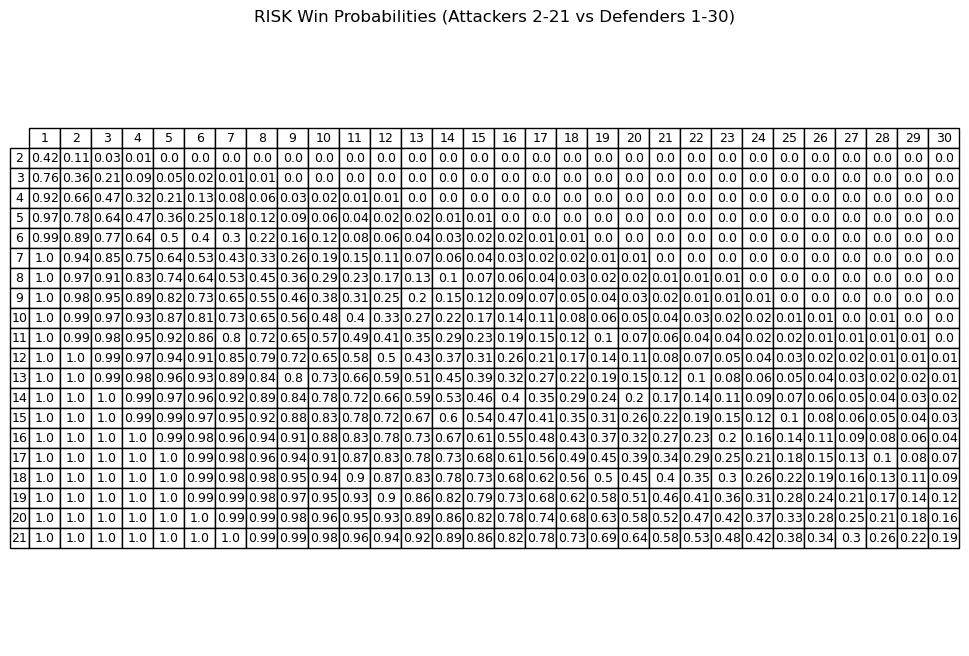

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Load the full table
table = np.load("../probability_table.npy")

# Extract the first 20 attackers and 20 defenders (rows 1-20, cols 1-20)
subset = table[1:21, 1:31]

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Hide axes

# Convert values to string with 2 decimals, replacing NaNs with '-'
table_data = np.where(np.isnan(subset), '-', np.round(subset, 2)).astype(str)

# Create the table
tbl = ax.table(cellText=table_data,
               rowLabels=range(2, 22),
               colLabels=range(1, 31),
               cellLoc='center',
               rowLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)  # Adjust cell size

plt.title("RISK Win Probabilities (Attackers 2-21 vs Defenders 1-30)")
plt.show()



### Future considerations

We never actually addressed the speed bottleneck, besides reducing the number of repetitions with attention to rigorous statistics. One of the main problems is that as troop counts get higher, the time it takes to simulate one battle increases (I expect the runtime scales linearly with troop counts, meaning 100 troops on each side = 100x longer to run). Once our table generator reaches the triple digits, we can expect significant pushback in its processing speed. Therefore, we could consider approximating a battle simulation by sampling from a normal distribution (see Random observations below).

### Random observations (WIP)

We can observe the pattern how strong attacks generally are with single simulations in unwinnable battles. We send a large number number of attackers into an impossibly larger number of defenders, and observe the ratio of attackers lost to defenders lost. By the law of large numbers, we should asymptote to some ratio:

In [4]:
ratios = []
for _ in range(10):
    attackers_lost = 10000
    remaining_attackers, remaining_defenders = battle(attackers_lost, 10**100)
    defenders_lost = 10**100 - remaining_defenders
    ratios.append(attackers_lost/defenders_lost)
for r in ratios:
    print(r)
print(f"Average ratio: {sum(ratios)/10}")

0.8765010079761592
0.8499065102838688
0.8646779074794639
0.8729050279329609
0.8486803021301875
0.861178091629349
0.8583690987124464
0.8779631255487269
0.8409014463504877
0.8813678829543451
Average ratio: 0.8632450400997996


By doing this, we might be able to get a "mean outcome" for battle simulations and with more math, a variance. Then for large battles (n>100), we could sample from a normal distribution to drastically increase the simulation speed!